In [46]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import sqlite3
from src.config import get_db_file, get_hussmann_supplementary_xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
con = sqlite3.connect(get_db_file())
df = pd.read_sql_query('select Barcode, Gene, Alias, outcome, fraction_per_barcode from outcomes where Alias is "MB01"', con)
df_idx = df.set_index(["Alias", "Gene", "Barcode", "outcome"])
print("loaded outcomes")
print(df_idx.head(2))

num_genes = df_idx.index.get_level_values("Gene").unique().shape[0]
num_barcodes = df_idx.index.get_level_values("Barcode").unique().shape[0]
num_outcomes = df_idx.index.get_level_values("outcome").unique().shape[0]

print("We have {} unique barcodes covering {} genes, producing {} outcomes".format(num_barcodes, num_genes, num_outcomes))

loaded outcomes
                                                          fraction_per_barcode
Alias Gene          Barcode         outcome                                   
MB01  0610009B22Rik 0610009B22Rik-1 DELETION|-10|0||0bp               0.001243
                                    DELETION|-10|19||1bp              0.000355
We have 86569 unique barcodes covering 18363 genes, producing 514242 outcomes


In [48]:
df_idx_norm_mean = df_idx.groupby(level=["Alias", "Gene", "outcome"]).mean()
totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean = df_idx_norm_mean[["fraction_per_barcode"]].div(totals, level="Gene").droplevel(level="Alias")
print("Normalised per Gene")
print(df_idx_norm_mean.head(2))

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_30384/3184723873.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")


Normalised per Gene
                                    fraction_per_barcode
Gene          outcome                                   
0610009B22Rik DELETION|-10|-1||3bp              0.000590
              DELETION|-10|0||0bp               0.001297


In [24]:

BASELINE_FREQUENCY = 0.002
frequent_outcomes = (df_idx_norm_mean.groupby("outcome").sum().div(num_genes)) > BASELINE_FREQUENCY
frequent_outcomes = frequent_outcomes[frequent_outcomes["fraction_per_barcode"]]
frequent_outcomes = frequent_outcomes.index
frequent_outcomes


df_idx_norm_mean_reduced = df_idx_norm_mean.loc[df_idx_norm_mean.index.get_level_values("outcome").isin(frequent_outcomes)]
totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")
df_idx_norm_mean_reduced = df_idx_norm_mean_reduced[["fraction_per_barcode"]].div(totals, level="Gene")
print("Normalised frequent outcomes")
print(df_idx_norm_mean_reduced.head(2))

df_outcome_profiles = df_idx_norm_mean_reduced.reset_index().pivot(index=["Gene"], columns="outcome", values="fraction_per_barcode").fillna(0)
df_outcome_profiles.index = df_outcome_profiles.index.str.lower()
print(df_outcome_profiles.head(2))
print("Repair outcome profiles created")

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_30384/2083203035.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean[["fraction_per_barcode"]].sum(level="Gene")


Normalised per Gene
                                    fraction_per_barcode
Gene          outcome                                   
0610009B22Rik DELETION|-10|-1||3bp              0.000590
              DELETION|-10|0||0bp               0.001297


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_30384/2083203035.py:15: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx_norm_mean_reduced[["fraction_per_barcode"]].sum(level="Gene")


Normalised frequent outcomes
                                   fraction_per_barcode
Gene          outcome                                  
0610009B22Rik DELETION|-10|2||1bp              0.003722
              DELETION|-10|5||3bp              0.006112
outcome        DELETION|-10|2||1bp  ...  WT|0|0||-1bp
Gene                                ...              
0610009b22rik             0.003722  ...      0.653424
0610010k14rik             0.004118  ...      0.674099

[2 rows x 19 columns]
Repair outcome profiles created


### Rank genes by summed correlation

Very simple method to rank genes. Genes that correlate highly with all other genes will be the "most similiar" to most other genes. These will get ranked towards the bottom. Note: This assumes that most genes don't have any impact on the repair outcome profiles. 


**This has another problem, it could also pick a point which correlates well with every other point in the plot, meaning it still picks a sort of "best average" point. This is very hard without any controls.** 

In [53]:
df_outcome_profiles_corr = df_outcome_profiles.T.corr()
df_outcome_profiles_corr

Gene,0610009b22rik,0610010k14rik,0610030e20rik,0610040j01rik,1110004f10rik,1110017d15rik,1110032a03rik,1110032f04rik,1110059e24rik,1110059g10rik,1110065p20rik,1190005i06rik,1190007i07rik,1500009l16rik,1600012h06rik,1600014c23rik,1700001c19rik,1700001j03rik,1700001k19rik,1700001l19rik,1700001o22rik,1700001p01rik,1700003e16rik,1700003f12rik,1700006a11rik,1700008o03rik,1700008p02rik,1700009n14rik,1700010b08rik,1700010d01rik,1700010i14rik,1700011l22rik,1700012a03rik,1700012b07rik,1700012b09rik,1700013d24rik,1700013g24rik,1700013h16rik,1700015g11rik,1700016c15rik,...,zpr1,zranb1,zranb2,zranb3,zrsr1,zrsr2,zscan10,zscan12,zscan18,zscan2,zscan20,zscan21,zscan22,zscan25,zscan26,zscan29,zscan4d,zscan4f,zscan5b,zswim1,zswim2,zswim3,zswim4,zswim5,zswim7,zswim8,zup1,zw10,zwilch,zwint,zxdb,zxdc,zyg11a,zyg11b,zyx,zzef1,zzz3,a,ccdc198,mei-04
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0610009b22rik,1.000000,0.999633,0.998627,0.998339,0.999375,0.999141,0.999036,0.999792,0.998168,0.997868,0.998874,0.999631,0.997968,0.994960,0.999498,0.999708,0.999642,0.999162,0.998858,0.999567,0.999713,0.999627,0.999530,0.999485,0.998423,0.999275,0.999674,0.998648,0.998814,0.998770,0.999637,0.997325,0.999020,0.999597,0.999582,0.998890,0.999705,0.999300,0.999403,0.999202,...,0.993007,0.999716,0.999457,0.999516,0.999240,0.999464,0.999444,0.999401,0.999334,0.999050,0.999687,0.999696,0.999091,0.999561,0.999648,0.999095,0.996537,0.992528,0.999291,0.999433,0.998744,0.999165,0.998774,0.999518,0.997196,0.999652,0.999238,0.999287,0.998639,0.999258,0.999622,0.999570,0.999528,0.999471,0.999651,0.999708,0.999550,0.998430,0.999727,0.999024
0610010k14rik,0.999633,1.000000,0.999353,0.999368,0.998700,0.999776,0.999480,0.999597,0.999124,0.999078,0.998128,0.999630,0.999174,0.996779,0.999786,0.999769,0.999602,0.999699,0.999582,0.999280,0.999874,0.999885,0.998795,0.999921,0.997449,0.999790,0.999745,0.999538,0.999448,0.999665,0.999824,0.998678,0.997968,0.999167,0.999833,0.999595,0.999625,0.998852,0.999626,0.998369,...,0.995540,0.999694,0.999457,0.999270,0.999726,0.998929,0.999701,0.999680,0.998555,0.999776,0.999614,0.999757,0.999796,0.999836,0.999730,0.998294,0.998215,0.994422,0.999854,0.999820,0.999550,0.999783,0.999648,0.999796,0.998350,0.999545,0.999570,0.999670,0.999303,0.998668,0.999804,0.999928,0.999639,0.999182,0.999108,0.999214,0.999237,0.999251,0.999092,0.998874
0610030e20rik,0.998627,0.999353,1.000000,0.999306,0.997466,0.999270,0.998662,0.998858,0.998719,0.998741,0.996826,0.998721,0.998877,0.997870,0.999387,0.998976,0.998654,0.998893,0.999227,0.998362,0.999115,0.999075,0.997539,0.999565,0.995105,0.999427,0.998921,0.999161,0.999813,0.999499,0.999585,0.998873,0.996528,0.997650,0.998903,0.999410,0.998714,0.997875,0.999077,0.996896,...,0.995996,0.998810,0.998505,0.998639,0.999613,0.997681,0.999587,0.999535,0.996996,0.999335,0.998951,0.999388,0.999194,0.999088,0.998840,0.996407,0.998059,0.995365,0.999510,0.999469,0.999418,0.999647,0.999371,0.999638,0.997850,0.998500,0.998578,0.998985,0.999109,0.997294,0.999388,0.999469,0.999024,0.998330,0.997489,0.998319,0.997821,0.999393,0.998108,0.998329
0610040j01rik,0.998339,0.999368,0.999306,1.000000,0.997023,0.999185,0.998445,0.998245,0.999424,0.999425,0.995916,0.998516,0.999468,0.998262,0.999458,0.998969,0.998295,0.999103,0.999033,0.997911,0.999226,0.999095,0.997083,0.999444,0.994883,0.999578,0.998980,0.999526,0.999307,0.999596,0.999101,0.999110,0.995905,0.997833,0.998988,0.999200,0.998747,0.997075,0.998579,0.997085,...,0.996835,0.998687,0.998571,0.997887,0.999367,0.997215,0.999403,0.999078,0.996822,0.999659,0.998679,0.998897,0.999512,0.999097,0.998927,0.996437,0.998568,0.995157,0.999679,0.999202,0.999451,0.999555,0.999618,0.999321,0.999343,0.998086,0.999117,0.998701,0.999128,0.997251,0.999397,0.999506,0.999071,0.997847,0.997406,0.997937,0.997707,0.998869,0.997526,0.998093
1110004f10rik,0.999375,0.998700,0.997466,0.997023,1.000000,0.997996,0.998125,0.999397,0.996484,0.995894,0.998685,0.999477,0.

In [54]:
ranked_genes_by_similarity = df_outcome_profiles_corr.sum().sort_values(ascending=True)

Text(0.5, 0, 'Rank')

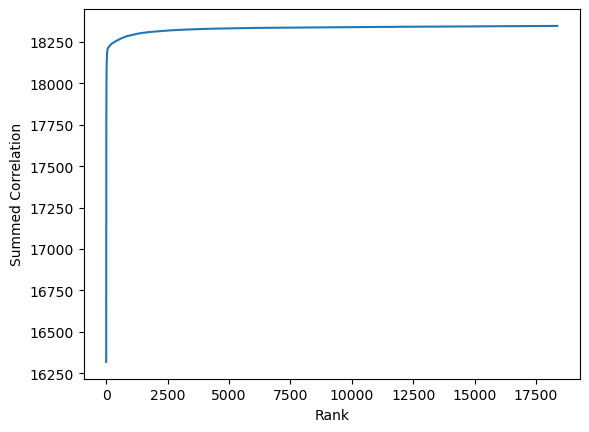

In [69]:
lineplt_df = ranked_genes_by_similarity.reset_index().rename(columns={0:"Summed Correlation"})
sns.lineplot(x=lineplt_df.index, y=lineplt_df["Summed Correlation"])
plt.xlabel("Rank")

Comparing these ranked genes to the known repair outcome genes as defined by hussmann et al, could give us an idea if our ranking is doing anything useful

In [70]:
hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.lower()
hussmann_repair_genes.head()

0    actl6a
1     actr5
2     actr8
3     aicda
4    alkbh2
Name: Gene, dtype: object

In [71]:
all_genes = df_outcome_profiles_corr.index.str.lower()
common_genes = np.intersect1d(all_genes, hussmann_repair_genes)
common_genes.shape

print("We have {} genes".format(all_genes.shape[0]))
print("Hussman et al has {} genes".format(hussmann_repair_genes.shape[0]))
print("We have {} genes in common with Hussman et al {}".format(common_genes.shape[0], common_genes.shape[0]/hussmann_repair_genes.shape[0]))

We have 18363 genes
Hussman et al has 476 genes
We have 442 genes in common with Hussman et al 0.9285714285714286


In [73]:
common_top_genes = np.intersect1d(ranked_genes_by_similarity[:1000].index.str.lower(), hussmann_repair_genes)
common_top_genes

print("The top 1000 ranked genes included {} known repair outcome genes".format(common_top_genes.shape[0]))

The top 1000 ranked genes included 73 known repair outcome genes


In [74]:
common_bottom_genes = np.intersect1d(ranked_genes_by_similarity[-1000:].index.str.lower(), hussmann_repair_genes)
common_bottom_genes

print("The bottom 100 ranked genes included {} known repair outcome genes".format(common_bottom_genes.shape[0]))

The bottom 100 ranked genes included 5 known repair outcome genes


In [59]:
from src.config import get_interim_dir

ranked_genes_by_similarity[-100:].index.to_series().to_csv(get_interim_dir() + "most_correlated_genes.txt", index=False)
ranked_genes_by_similarity[:100].index.to_series().to_csv(get_interim_dir() + "least_correlated_genes.txt", index=False)

In [60]:
ranked_genes_by_similarity

Gene
trp53            16318.564491
ugt2b38          17222.408329
gm7361           17261.485785
vmn1r128         17472.841975
obp1a            17577.393712
                     ...     
0610010k14rik    18346.531541
cyb561a3         18346.533676
rap2b            18346.575033
sgsm1            18346.624359
foxa2            18346.649245
Length: 18363, dtype: float64

In [61]:
hussmann_guide_activity = pd.read_csv(get_interim_dir() + "hussman_guides_chi_squared.txt")
hussmann_guide_activity["gene"] = hussmann_guide_activity["variable_guide"].apply(lambda x: x.split("_")[0].lower())
hussmann_repair_gene_activity = hussmann_guide_activity.groupby("gene").mean().reset_index()
hussmann_repair_gene_activity["our_score"] = hussmann_repair_gene_activity["gene"].apply(lambda x: ranked_genes_by_similarity[x] if x in ranked_genes_by_similarity.index else np.nan)
hussmann_repair_gene_activity = hussmann_repair_gene_activity.dropna()
hussmann_repair_gene_activity

,gene,chi_squared,our_score
0,abraxas1,78.878102,18337.179625
1,actl6a,96.619220,18307.543247
2,actr5,85.240843,18215.194005
3,actr8,230.145800,18319.362311
4,aicda,87.013042,18343.515154
...,...,...,...
472,ybx3,74.905341,18343.614570
473,yeats4,96.568953,18313.896387
474,yy1,74.650793,18335.196282
475,znhit1,85.580348,18342.179424


In [62]:
hussmann_repair_gene_activity["chi_squared"].corr(hussmann_repair_gene_activity["our_score"], method="spearman")

-0.15274350179388538

Questions: 

 - Why are known repair genes ranked at the bottom? It's possible that these genes are involved in repair, but their function could be replaced by other repair genes. Thus, removing these genes alone has no impact on the repair outcome profile.
 - It is also possible that the sgRNAs for these genes are not efficient and knocking out the gene.